### Setup

In [44]:
# Main
import numpy as np
import pandas as pd
import datetime as dt
from statsmodels.tsa.tsatools import lagmat

# Modeling
import statsmodels.api as sm
from statsmodels.tsa.tsatools import add_trend

# Unit root
from arch.unitroot import ADF, DFGLS, PhillipsPerron, KPSS, ZivotAndrews
from quantileADF import QAR, comparisonPlot
from quantileTAR import QTAR, QTAR_CustomRport
from report import countryReport, reportCountries

# Tests and function
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from statsmodels.regression.linear_model import OLS

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Setup
repoUrl = 'https://raw.githubusercontent.com/vlad-yeghiazaryan/QADF/master/data/'
broadREERsUrl = repoUrl + 'broadREERs.csv'
narrowREERsUrl = repoUrl + 'narrowREERs.csv'
pd.io.formats.excel.ExcelFormatter.header_style = None

In [45]:
def univariate(data):
    univariateTests = pd.DataFrame()
    univariateTests['ADF'] = data.apply(lambda col: ADF(col).pvalue)
    univariateTests['DFGLS'] = data.apply(lambda col: DFGLS(col).pvalue)
    univariateTests['PP'] = data.apply(lambda col: PhillipsPerron(col).pvalue)
    univariateTests['KPSS'] = data.apply(lambda col: KPSS(col).pvalue)
    univariateTests['ZA'] = data.apply(lambda col: ZivotAndrews(col).pvalue)
    return univariateTests.applymap(lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)

In [46]:
def comparisonPlots(data,fileName='changesOverQuantiles'):
    figs = []
    for index, pos in enumerate(range(0, data.shape[1], 3)):
        columns = data.columns[pos: min(data.shape[1], pos+3)]
        figsize = (len(columns)*5, 6)
        countries = data[columns]
        fig = comparisonPlot(countries, figsize=figsize)
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{index+1}', dpi = 150)
    return figs

In [47]:
def markovRegimeSwitchingPlots(data, fileName='regimeSwitchingProbabilities'):
    figs = []
    for i, pos in enumerate(range(0, data.shape[1], 2)):
        columns = data.columns[pos: min(data.shape[1], pos+2)]
        figsize = (len(columns)*5, 6)
        fig = plt.figure()
        for index, country in enumerate(columns):
            mainModel = QAR(data[country])
            ax = fig.add_subplot(1, len(columns), index+1)
            mod = sm.tsa.MarkovRegression(mainModel.y, trend='c', k_regimes=2, order=2, freq='MS').fit()
            ylabel = 'Probability of being in the high regime'
            title = mainModel.name
            ax = mod.smoothed_marginal_probabilities[1].plot(title=title,ylabel=ylabel, figsize=(12,3))
            ax.axvline('2015-1-1', color='black')
            trans = ax.get_xaxis_transform()
            plt.text('2015-1-1', -.1, 'EAEU', transform=trans, weight='bold')
            ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{i+1}', dpi = 150)
    return figs

In [48]:
def saveToExcel(dataframe, path, def_properties={}):
    # Setup
    writer = pd.ExcelWriter(path)
    dataframe.style.set_properties(**def_properties).to_excel(writer)

    def dummyCriteria(f): return {'type': 'cell',
                                  'criteria': '!=', 'value': 0, 'format': f}

    def excel_colnum_string(n):
        string = ""
        while n > 0:
            n, remainder = divmod(n - 1, 26)
            string = chr(65 + remainder) + string
        return string

    # Accessing
    workbook = writer.book
    worksheet = writer.sheets['Sheet1']
    colLetter = excel_colnum_string(dataframe.shape[1]+1)
    tableRange = 'A1:'+colLetter+str(dataframe.shape[0]+1)
    header = 'A1:'+colLetter+'1'
    footer = 'A'+str(dataframe.shape[0]+1) + \
        ':'+colLetter+str(dataframe.shape[0]+1)
    indexCol = 'A1:'+'A'+str(dataframe.shape[0]+1)

    # Styles
    defaultFormat = {'font_name': 'Calibri', 'font_size': 8,
                     'bg_color': '#FFFFFF',
                     'align': 'center',
                     'valign': 'vcenter',
                     'border': 0,
                     'shrink': True,
                     'text_wrap': True}
    columnFormat = workbook.add_format(defaultFormat)
    columnFormat.set_font_size(8)
    headerFormat = workbook.add_format(
        {**defaultFormat, **{'top': 5, 'bottom': 2, 'bold': True}})
    footerFormat = workbook.add_format({**defaultFormat, **{'bottom': 5}})
    indexFormat = workbook.add_format({**defaultFormat, **{'align': 'left'}})

    # Applying Styles
    worksheet.conditional_format(tableRange, dummyCriteria(columnFormat))
    worksheet.conditional_format(header, dummyCriteria(headerFormat))
    worksheet.conditional_format(footer, dummyCriteria(footerFormat))
    worksheet.conditional_format(indexCol, dummyCriteria(indexFormat))
    writer.save()
    print('Table saved to:', path)

In [49]:
data = pd.read_pickle('data/dataset2000.pkl')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2000-01-01 to 2020-12-01
Freq: MS
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Armenia             252 non-null    float64
 1   Belarus             252 non-null    float64
 2   Kazakhstan          252 non-null    float64
 3   Kyrgyz Republic     252 non-null    float64
 4   Russian Federation  252 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB


In [50]:
# Changing data
dataLogs = data.apply(np.log, axis=1)
dataPtC = dataLogs.diff()[1:]

### REERs of EAEU countries

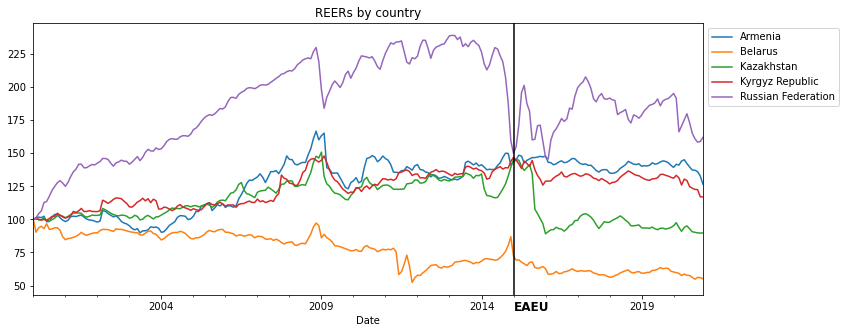

In [10]:
ax = data.plot(kind='line', subplots=False, sharey=True, 
          layout=(1,1), figsize=(12, 5), title='REERs by country', legend=False)

ax.legend(bbox_to_anchor=(1, 1), loc='best')
mark = '2015'
ax.axvline(mark+'-1-1', color='black')
ax.text(mark+'-1-1', -0.06, 'EAEU', transform=ax.get_xaxis_transform(), weight='bold', fontsize='large')

# plt.savefig('Outputs/REERsByCountry', dpi = 150, bbox_inches='tight')
plt.show()

In [12]:
colNames = {
    'count': 'N',
    'mean': 'Mean',
    'std': 'St.dev.',
    'min': 'Min.',
    'max': 'Max.',
    '50%': 'Median',
}
tests = ['Jarque-Bera', 'Jarque-Bera (P-value)', 'Skewness', 'Kurtosis']
include = ['N', 'Mean', 'Median', 'Min.', 'Max.', 'St.dev.',
           'Skewness', 'Kurtosis', 'Jarque-Bera', 'Jarque-Bera (P-value)']

# Summary Setup
summaryStatistics = data.describe().T
JB = data.apply(jarque_bera).T
summaryStatistics[tests] = JB
summaryStatistics.rename(columns=colNames, inplace=True)
summaryTable = summaryStatistics[include].applymap(
    lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)
summaryTable.index.name = 'Countries'
# saveToExcel(summaryTable, path="Outputs/summaryStatistics.xlsx", def_properties={'text-align': 'center'})
summaryTable

,N,Mean,Median,Min.,Max.,St.dev.,Skewness,Kurtosis,Jarque-Bera,Jarque-Bera (P-value)
Countries,,,,,,,,,,
Armenia,252,127.879,135.958,89.885,166.704,19.159,-0.587,1.975,25.519,0.000
Belarus,252,75.912,77.463,52.366,100,13.029,-0.108,1.463,25.287,0.000
Kazakhstan,252,112.865,110.283,89.110,150.867,14.969,0.286,1.981,14.343,0.001
Kyrgyz Republic,252,124.187,128.753,99.346,147.947,12.583,-0.278,1.844,17.271,0.000
Russian Federation,252,186.077,189.731,100,239.097,33.296,-0.342,2.300,10.048,0.007


In [14]:
univariateTable = univariate(dataLogs)
univariateTable.index.name = 'Countries'
# saveToExcel(univariateTable, path='Outputs/univariateTests.xlsx')
univariateTable

,ADF,DFGLS,PP,KPSS,ZA
Countries,,,,,
Armenia,0.431,0.422,0.465,0.000,0.135
Belarus,0.822,0.865,0.676,0.000,0.157
Kazakhstan,0.329,0.097,0.611,0.033,0.000
Kyrgyz Republic,0.208,0.423,0.225,0.000,0.386
Russian Federation,0.028,0.627,0.022,0.003,0.279


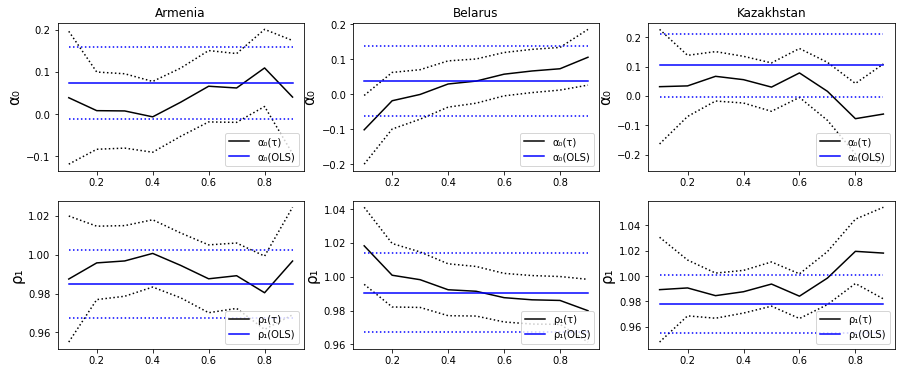

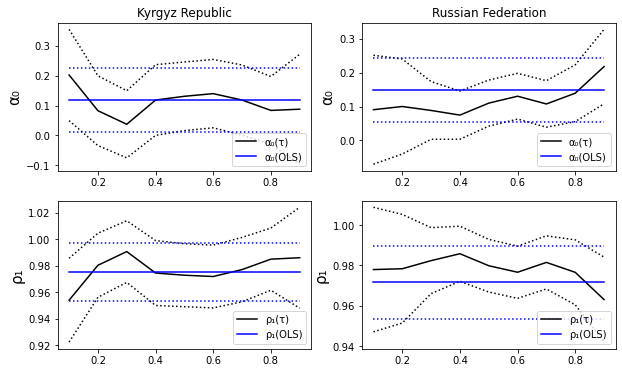

In [15]:
comparisonPlots(dataLogs)
plt.show()

/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


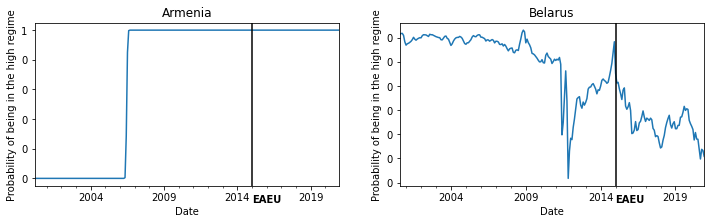

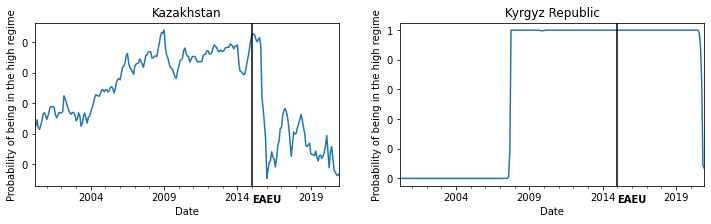

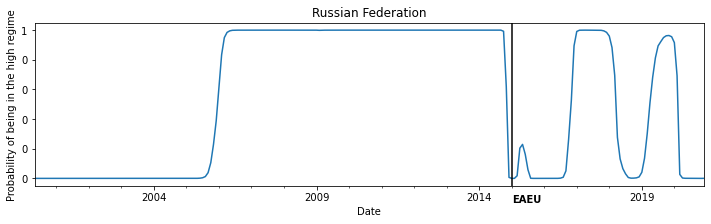

In [16]:
markovRegimeSwitchingPlots(data)
plt.show()

### Covergence in subsamples

#### Classic ADF test

In [17]:
adf = ADF(dataLogs['Armenia'])
adf.regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     5.441
Date:                Tue, 03 Aug 2021   Prob (F-statistic):            0.00487
Time:                        02:40:20   Log-Likelihood:                 598.30
No. Observations:                 250   AIC:                            -1191.
Df Residuals:                     247   BIC:                            -1180.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0151      0.009     -1.699      0.090      -0.033       0.002
Diff.L1        0.1820      0.063      2.895      0.004       0.058       0.306
const          0.0736      0.043      1.715      0.088      -0.011       0.158
==============================================================================
Omnibus:                      126.986   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2159.310
Skew:                          -1.563   Prob(JB):                         0.00
Kurtosis:                      17.054   Cond. No.                         221.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
adf.summary()

Test Statistic,-1.699
P-value,0.431
Lags,1


#### Standard ADF test

In [19]:
# This replicates the results above with the ADF class
lags = 1 # dynamically scalable
diff = dataLogs['Armenia'].diff(1)
d_y = diff[1+lags:]
y_1 = dataLogs['Armenia'].shift(1).rename('Level.L1')
d_y_lags = pd.DataFrame(lagmat(diff, maxlag=lags), index=diff.index,
                        columns=['Diff.L'+str(i) for i in range(1, lags+1)])
X = sm.add_constant(pd.concat([y_1, d_y_lags], axis=1))[1+lags:]
res = OLS(d_y, exog=X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     5.441
Date:                Tue, 03 Aug 2021   Prob (F-statistic):            0.00487
Time:                        02:40:37   Log-Likelihood:                 598.30
No. Observations:                 250   AIC:                            -1191.
Df Residuals:                     247   BIC:                            -1180.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0736      0.043      1.715      0.088      -0.011       0.158
Level.L1      -0.0151      0.009     -1.699      0.090      -0.033       0.002
Diff.L1        0.1820      0.063      2.895      0.004       0.058       0.306
==============================================================================
Omnibus:                      126.986   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2159.310
Skew:                          -1.563   Prob(JB):                         0.00
Kurtosis:                      17.054   Cond. No.                         221.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### ADF test with dummies

In [20]:
# ADF test with pre- and post-EAEU dummies
lags = 1
diff = dataLogs['Armenia'].diff(1)
d_y = diff[1+lags:]
EAEU = (dataLogs.index > '2015-01-01').astype(int)
y_1 = dataLogs['Armenia'].shift(1).rename('Level.L1')
y_1_post = pd.DataFrame(y_1*EAEU).add_suffix('_post')
y_1_pre =  pd.DataFrame(y_1*(1-EAEU)).add_suffix('_pre')
d_y_lags = pd.DataFrame(lagmat(diff, maxlag=lags), index=diff.index,
                        columns=['Diff.L'+str(i) for i in range(1, lags+1)])
X = sm.add_constant(pd.concat([y_1_pre, y_1_post, d_y_lags], axis=1))[1+lags:]
res = OLS(d_y, exog=X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.640
Date:                Tue, 03 Aug 2021   Prob (F-statistic):             0.0134
Time:                        02:40:46   Log-Likelihood:                 598.34
No. Observations:                 250   AIC:                            -1189.
Df Residuals:                     246   BIC:                            -1175.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0677      0.048      1.413      0.159      -0.027       0.162
Level.L1_pre     -0.0138      0.010     -1.380      0.169      -0.033       0.006
Level.L1_post    -0.0140      0.010     -1.444      0.150      -0.033       0.005
Diff.L1           0.1806      0.063      2.856      0.005       0.056       0.305
==============================================================================
Omnibus:                      129.171   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2221.684
Skew:                          -1.598   Prob(JB):                         0.00
Kurtosis:                      17.250   Cond. No.                         187.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# ADF test with post-EAEU dummy (Level.L1_post: beta_1 - beta_2 version)
X = sm.add_constant(pd.concat([y_1, y_1_post, d_y_lags], axis=1))[1+lags:]
res = OLS(d_y, exog=X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.640
Date:                Tue, 03 Aug 2021   Prob (F-statistic):             0.0134
Time:                        02:40:48   Log-Likelihood:                 598.34
No. Observations:                 250   AIC:                            -1189.
Df Residuals:                     246   BIC:                            -1175.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0677      0.048      1.413      0.159      -0.027       0.162
Level.L1         -0.0138      0.010     -1.380      0.169      -0.033       0.006
Level.L1_post    -0.0002      0.001     -0.280      0.780      -0.002       0.001
Diff.L1           0.1806      0.063      2.856      0.005       0.056       0.305
==============================================================================
Omnibus:                      129.171   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2221.684
Skew:                          -1.598   Prob(JB):                         0.00
Kurtosis:                      17.250   Cond. No.                         234.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### ADF test with 2 models vs 1 model

In [22]:
# ADF test with 2 models (before/after)
X = sm.add_constant(pd.concat([y_1, d_y_lags], axis=1))[1+lags:]
res = OLS(d_y[:'2015-01-01'], exog=X[:'2015-01-01']).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     3.152
Date:                Tue, 03 Aug 2021   Prob (F-statistic):             0.0452
Time:                        02:40:59   Log-Likelihood:                 407.08
No. Observations:                 179   AIC:                            -808.2
Df Residuals:                     176   BIC:                            -798.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0668      0.054      1.233      0.219      -0.040       0.174
Level.L1      -0.0136      0.011     -1.203      0.230      -0.036       0.009
Diff.L1        0.1694      0.074      2.281      0.024       0.023       0.316
==============================================================================
Omnibus:                       90.451   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1114.051
Skew:                          -1.515   Prob(JB):                    1.22e-242
Kurtosis:                      14.840   Cond. No.                         194.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# ADF test with 2 models (before/after)
X = sm.add_constant(pd.concat([y_1, d_y_lags], axis=1))[1+lags:]
res = OLS(d_y['2015-01-01':], exog=X['2015-01-01':]).fit()
res.summary()
# Constant is higher in this one

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8611
Date:                Tue, 03 Aug 2021   Prob (F-statistic):              0.427
Time:                        02:41:03   Log-Likelihood:                 211.29
No. Observations:                  72   AIC:                            -416.6
Df Residuals:                      69   BIC:                            -409.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1032      0.326      0.316      0.753      -0.547       0.754
Level.L1      -0.0211      0.066     -0.320      0.750      -0.152       0.110
Diff.L1        0.1555      0.119      1.310      0.195      -0.081       0.392
==============================================================================
Omnibus:                       11.055   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               12.142
Skew:                          -0.751   Prob(JB):                      0.00231
Kurtosis:                       4.338   Cond. No.                     1.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### ADF with trend

In [24]:
# In pre- and post-EAEU dummies (as one model) they share the costant. Let's see if adding a trend changes things.
print('One Model with trend')
X = add_trend(pd.concat([y_1_pre, y_1_post, d_y_lags], axis=1), 'ct')[1+lags:]
res = OLS(d_y, exog=X).fit()
res.summary()

One Model with trend


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     3.291
Date:                Tue, 03 Aug 2021   Prob (F-statistic):             0.0119
Time:                        02:41:11   Log-Likelihood:                 599.45
No. Observations:                 250   AIC:                            -1189.
Df Residuals:                     245   BIC:                            -1171.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Level.L1_pre     -0.0332      0.016     -2.015      0.045      -0.066      -0.001
Level.L1_post    -0.0347      0.017     -2.040      0.042      -0.068      -0.001
Diff.L1           0.1931      0.064      3.035      0.003       0.068       0.318
const             0.1536      0.075      2.042      0.042       0.005       0.302
trend          7.621e-05   5.15e-05      1.480      0.140   -2.52e-05       0.000
==============================================================================
Omnibus:                      119.890   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1861.991
Skew:                          -1.469   Prob(JB):                         0.00
Kurtosis:                      16.043   Cond. No.                     8.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
print('Before with trend')
X = add_trend(pd.concat([y_1, d_y_lags], axis=1), 'ct')[1+lags:]
res = OLS(d_y[:'2015-01-01'], exog=X[:'2015-01-01']).fit()
res.summary()

Before with trend


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     3.242
Date:                Tue, 03 Aug 2021   Prob (F-statistic):             0.0234
Time:                        02:41:14   Log-Likelihood:                 408.77
No. Observations:                 179   AIC:                            -809.5
Df Residuals:                     175   BIC:                            -796.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0448      0.020     -2.192      0.030      -0.085      -0.004
Diff.L1        0.1865      0.074      2.508      0.013       0.040       0.333
const          0.2054      0.093      2.208      0.029       0.022       0.389
trend          0.0001   6.57e-05      1.827      0.069   -9.62e-06       0.000
==============================================================================
Omnibus:                       79.324   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              841.381
Skew:                          -1.309   Prob(JB):                    1.98e-183
Kurtosis:                      13.293   Cond. No.                     5.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
print('After with trend')
X = add_trend(pd.concat([y_1, d_y_lags], axis=1), 'ct')[1+lags:]
res = OLS(d_y['2015-01-01':], exog=X['2015-01-01':]).fit()
res.summary()
# I'll go with a single model with a shared constant, trend and asymmetric adjustments

After with trend


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Armenia   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.472
Date:                Tue, 03 Aug 2021   Prob (F-statistic):             0.0691
Time:                        02:41:23   Log-Likelihood:                 214.13
No. Observations:                  72   AIC:                            -420.3
Df Residuals:                      68   BIC:                            -411.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.1123      0.074     -1.507      0.136      -0.261       0.036
Diff.L1        0.1997      0.116      1.714      0.091      -0.033       0.432
const          0.5984      0.379      1.579      0.119      -0.158       1.355
trend         -0.0002   8.44e-05     -2.362      0.021      -0.000    -3.1e-05
==============================================================================
Omnibus:                       13.391   Durbin-Watson:                   1.554
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.253
Skew:                          -0.794   Prob(JB):                     0.000179
Kurtosis:                       4.798   Cond. No.                     5.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ADF test results

Standard: t-stat = -1.664, p-value = 0.450

Pre-EAEU: t-stat = -1.438

Post-EAEU: t-stat = -1.494

Diff: t-stat = -0.084

### Capturing Convergence

In [23]:
y = data['Belarus']
EAEU = pd.Series((y.index > '2014-12-01').astype(int), index=y.index, name='EAEU')
qtar_model = QTAR(y, EAEU, 'ct', pmax=12, ic='AIC')
res = qtar_model.fit(0.5)

In [24]:
res.summary()

quantile: 0.5
Lags: 6
α₀(τ): 9.5236
ρ₁(τ): 0.8991
α₁(τ): -0.00537
δ²: 0.25
tₙ(τ): -4.8044


In [25]:
res.regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                Belarus   Pseudo R-squared:               0.8975
Model:                       QuantReg   Bandwidth:                      0.9092
Method:                 Least Squares   Sparsity:                        2.898
Date:                Tue, 03 Aug 2021   No. Observations:                  245
Time:                        13:06:02   Df Residuals:                      235
                                        Df Model:                            9
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.5236      2.035      4.679      0.000       5.514      13.534
Belarus.L1               0.8991      0.021     42.964      0.000       0.858       0.940
post-EAEU_Belarus.L1    -0.0054      0.005     -1.014      0.312      -0.016       0.005
Diff.L1                  0.1498      0.042      3.533      0.000       0.066       0.233
Diff.L2                 -0.0834      0.043     -1.960      0.051      -0.167       0.000
Diff.L3                  0.0301      0.043      0.703      0.483      -0.054       0.115
Diff.L4                  0.0061      0.043      0.143      0.886      -0.078       0.090
Diff.L5                  0.0214      0.041      0.525      0.600      -0.059       0.102
Diff.L6                 -0.1171      0.040     -2.936      0.004      -0.196      -0.039
trend                   -0.0151      0.004     -3.646      0.000      -0.023      -0.007
========================================================================================

The condition number is large, 3.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
quantiles = np.arange(0.1, 1, 0.1)
res.fitForQuantiles(quantiles)

/Users/victor_yerz/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


,Lags,α₀(τ),ρ₁(τ),α₁(τ),δ²,tₙ(τ),QKS,name
quantile,,,,,,,,
0.1,6,8.9843,0.8866,-0.00558,0.316,-1.9050,5.1136,Belarus
0.2,6,10.4360,0.8808,-0.00913,0.276,-3.9013,5.1136,Belarus
0.3,6,9.2477,0.8984,-0.00075,0.277,-4.1011,5.1136,Belarus
0.4,6,9.2345,0.9014,-0.00266,0.261,-5.1136,5.1136,Belarus
0.5,6,9.5236,0.8991,-0.00537,0.250,-4.8044,5.1136,Belarus
0.6,6,7.8159,0.9187,-0.01188,0.245,-3.8647,5.1136,Belarus
0.7,6,7.3408,0.9257,-0.01976,0.231,-2.9234,5.1136,Belarus
0.8,6,4.7978,0.9537,-0.03072,0.200,-1.6762,5.1136,Belarus
0.9,6,5.1247,0.9523,-0.05306,0.174,-0.8058,5.1136,Belarus


In [51]:
y = data['Belarus']
EAEU = pd.Series((y.index >= '2015-01-01').astype(int), index=y.index, name='EAEU')
qtar_model = QTAR(y, EAEU, 'ct', pmax=12, ic='AIC')
levels = [0.01,0.05,0.1]
quantiles = np.arange(0.1, 1, 0.1)
drop = ['δ²', 'Lags']
reps = 100

from statsmodels.tools.sm_exceptions import IterationLimitWarning
import warnings
warnings.simplefilter('ignore', IterationLimitWarning)

In [52]:
report, results = countryReport(qtar_model, quantiles, reps, levels, 
                                customReport=QTAR_CustomRport, dropColumns=drop)

Belarus finished in: 212.64s


In [53]:
report

quantile                 0.1            0.2            0.3            0.4  \
name                                                                        
Belarus α₀(τ)     8.98(0.16)  10.44(0.02)**   9.25(0.01)**   9.23(0.01)**   
        ρ₁(τ)     0.89(0.16)   0.88(0.03)**    0.9(0.02)**    0.9(0.03)**   
        α₁(τ)  -0.0056(0.36)  -0.0091(0.1)*  -0.0008(0.43)  -0.0027(0.28)   
        tₙ(τ)    -1.91(0.16)  -3.9(0.01)***  -4.1(0.01)***  -5.11(0.0)***   
        QKS    5.11(0.01)***                                                

quantile                 0.5              0.6              0.7  \
name                                                             
Belarus α₀(τ)   9.52(0.01)**      7.82(0.05)*       7.34(0.06)   
        ρ₁(τ)   0.9(0.01)***      0.92(0.06)*      0.93(0.06)*   
        α₁(τ)  -0.0054(0.17)  -0.0119(0.03)**  -0.0198(0.0)***   
        tₙ(τ)   -4.8(0.0)***   -3.86(0.01)***     -2.92(0.09)*   
        QKS                                                      

quantile                   0.8              0.9  
name                                             
Belarus α₀(τ)        4.8(0.27)       5.12(0.48)  
        ρ₁(τ)       0.95(0.18)       0.95(0.37)  
        α₁(τ)  -0.0307(0.0)***  -0.0531(0.0)***  
        tₙ(τ)      -1.68(0.28)      -0.81(0.45)  
        QKS